# 偶极矩的测定

实验一开始时需要根据环己烷和乙酸乙酯的密度、摩尔质量来计算需要有多少体积的乙酸乙酯配成溶液，才能达到给定的摩尔分数。

In [1]:
rho_hr = 0.77855 # 环己烷密度
M_hr = 84.16 # 环己烷摩尔质量
rho_yi = 0.9003 # 乙酸乙酯密度
M_yi = 88.12 # 乙酸乙酯摩尔质量

In [2]:
def V(v):
    # 给定一个乙酸乙酯体积v，计算乙酸乙酯摩尔浓度，注意总量是25
    A = rho_hr * (25 - v)  / M_hr
    B = rho_yi * v / M_yi
    return B / (A + B)


In [3]:
from scipy.optimize import root_scalar
x_is = [0.05, 0.10, 0.15, 0.20]
res = []
for x_i in x_is:

    def VV(v):
        return V(v) - x_i
    r = root_scalar(VV, bracket=[-1, 25])
    res.append(r.root)
res # 此数据为应该量取的环己烷体积，单位mL

[1.1371974254356354, 2.285248827767572, 3.4443103457464983, 4.614541127375976]

## 测定数据

这些数据是我做实验的时候测得，如果想自己应用需要改改，数据都在`数据`文件夹里

In [4]:
import pandas as pd
import os.path
data_path = os.path.join('数据','偶极矩')
weight_table = pd.read_csv(os.path.join(data_path, '重量.csv'))
weight_table

,组别,空容量瓶,乙酸,环己烷
0,0.05,17.0974,17.8990,36.3779
1,0.10,28.9117,30.6767,48.3565
2,0.15,24.7731,27.6383,44.2263
3,0.20,24.6930,28.4962,44.4122


In [5]:
n_table = pd.read_csv(os.path.join(data_path, '折射率.csv'))
n_table

,组别,n1,n2
0,水,1.3610,1.3600
1,0.05,1.4230,1.4230
2,0.10,1.4198,1.4210
3,0.15,1.4188,1.4189
4,0.20,1.4180,1.4180


In [6]:
rho_table = pd.read_csv(os.path.join(data_path, '密度.csv'))
rho_table

,组别,空瓶质量,5mL质量
0,水,9.1749,14.0500
1,0.05,9.1749,13.0726
2,0.10,9.1749,13.0932
3,0.15,9.1752,13.1171
4,0.20,9.1850,13.2194


In [7]:
c_table = pd.read_csv(os.path.join(data_path, '电容.csv'))
c_table

,组别,电容1,电容2
0,空气,5.56,5.56
1,环己烷,8.14,8.14
2,0.05,8.39,8.38
3,0.10,8.80,8.78
4,0.15,8.88,8.89
5,0.20,8.93,8.92


## 按照实验指导书作图

### 计算实际物质的量分数

实际的物质的量分数计算公式为

$$
n = \frac{m_1 - m_0}{M} 
$$

$$
n' = \frac{m_2 - m_1}{M'} 
$$

$$
w = \frac{n}{n + n'}
$$

这里$n$为乙酸乙酯物质的量，$n'$为环己烷物质的量，$m_0, m_1, m_2$分别为先后测定的三个数值，也就是空容量瓶、乙酸、环己烷

In [8]:
def get_w(weight_table: pd.DataFrame) -> pd.DataFrame:
    n = (weight_table['乙酸'] - weight_table['空容量瓶']) / M_yi
    n_ = (weight_table['环己烷'] - weight_table['乙酸']) / M_hr
    w = n / (n + n_)
    return pd.DataFrame(
        {
            "组别": weight_table['组别'],
            "x": w
        }
    )
w = get_w(weight_table)
w

,组别,x
0,0.05,0.039782
1,0.10,0.087046
2,0.15,0.141605
3,0.20,0.185811


### 绘制折射率$n$与$x_2$的关系，求出$\gamma$值

In [9]:
# 先计算平均值，也就是4组的n
n = (n_table['n1'] + n_table['n2']) / 2
n = n[1:]
n

1    1.42300
2    1.42040
3    1.41885
4    1.41800
dtype: float64

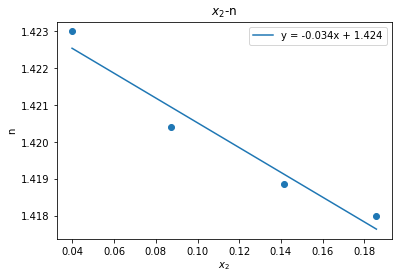

In [10]:
# 绘制图像（线性回归）
from matplotlib import pyplot as plt
from sklearn import linear_model
import numpy as np

model = linear_model.LinearRegression()
figure1_reg = model.fit(np.array(w['x']).reshape(-1, 1), n)
x_pred = np.linspace(w['x'][0], w['x'][3], 100).reshape(-1, 1)
y_pred = figure1_reg.predict(x_pred)
plt.plot(x_pred, y_pred, label='y = %.3fx + %.3f' % (figure1_reg.coef_[0], figure1_reg.intercept_))
plt.scatter(w['x'], n)
plt.xlabel('$x_2$')
plt.ylabel('n')
plt.title('$x_2$-n')
plt.legend()

#### 计算$\gamma$值

由于
$$
n_{溶} = n_1(1 + \gamma x_2)
$$

而回归方程为
$$
y_{n_溶} = ax_2 + b
$$

对照系数可以计算得：

$$
n_1 = b \qquad \gamma = \frac{a}{b}
$$

In [11]:
gamma = figure1_reg.coef_[0] / figure1_reg.intercept_
gamma

-0.023617939251635446

### 计算环己烷以及各种溶液的密度$\rho$，作$\rho-x_2$图，求出$\beta$值

In [12]:
rho = rho_table['5mL质量'] - rho_table['空瓶质量']
rho = rho[1:] / 5
rho # 单位：g/mL

1    0.77954
2    0.78366
3    0.78838
4    0.80688
dtype: float64

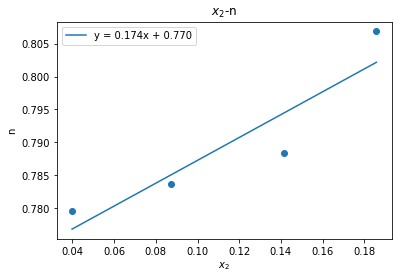

In [13]:
figure2_reg = model.fit(np.array(w['x']).reshape(-1, 1), rho)
x_pred = np.linspace(w['x'][0], w['x'][3], 100).reshape(-1, 1)
y_pred = figure2_reg.predict(x_pred)
plt.plot(x_pred, y_pred, label='y = %.3fx + %.3f' % (figure2_reg.coef_[0], figure2_reg.intercept_))
plt.scatter(w['x'], rho)
plt.xlabel('$x_2$')
plt.ylabel('n')
plt.title('$x_2$-n')
plt.legend()

利用公式
$$
\beta = \frac{a}{b}
$$

计算$\beta$。

In [14]:
beta = figure2_reg.coef_[0] / figure2_reg.intercept_
beta

0.22594694342090157